In [26]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import re

In [27]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [28]:
from nltk import word_tokenize

In [29]:
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")
df_valid = pd.read_csv("data/valid.csv")

In [30]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
MAX_SEQUENCE_LENGTH = 250
EMBEDDING_DIM = 100

train_tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
test_tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
valid_tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)

train_tokenizer.fit_on_texts(df_train["clean_text"].values)
train_word_index = train_tokenizer.word_index
print(f"Found {len(train_word_index)} unique tokens.")

test_tokenizer.fit_on_texts(df_test["clean_text"].values)
test_word_index = test_tokenizer.word_index
print(f"Found {len(test_word_index)} unique tokens.")

valid_tokenizer.fit_on_texts(df_valid["clean_text"].values)
valid_word_index = valid_tokenizer.word_index
print(f"Found {len(valid_word_index)} unique tokens.")

Found 7923 unique tokens.
Found 4963 unique tokens.
Found 1905 unique tokens.


In [31]:
X_train = train_tokenizer.texts_to_sequences(df_train["clean_text"].values)
X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_train.shape)

Y_train = pd.get_dummies(df_train["label"]).values
print('Shape of label tensor:', Y_train.shape)

Shape of data tensor: (3257, 250)
Shape of label tensor: (3257, 4)


In [32]:
X_test = train_tokenizer.texts_to_sequences(df_test["clean_text"].values)
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_test.shape)

Y_test = pd.get_dummies(df_test["label"]).values
print('Shape of label tensor:', Y_test.shape)

Shape of data tensor: (1420, 250)
Shape of label tensor: (1420, 4)


In [33]:
X_valid = train_tokenizer.texts_to_sequences(df_valid["clean_text"].values)
X_valid = pad_sequences(X_valid, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_valid.shape)

Y_valid = pd.get_dummies(df_valid["label"]).values
print('Shape of label tensor:', Y_valid.shape)

Shape of data tensor: (374, 250)
Shape of label tensor: (374, 4)


In [34]:
len(X_train)+len(X_test)+len(X_valid)

5051

In [49]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_train.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(4, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
print(model.summary())

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 250, 100)          5000000   
                                                                 
 spatial_dropout1d_10 (Spati  (None, 250, 100)         0         
 alDropout1D)                                                    
                                                                 
 lstm_10 (LSTM)              (None, 100)               80400     
                                                                 
 dense_10 (Dense)            (None, 4)                 404       
                                                                 
Total params: 5,080,804
Trainable params: 5,080,804
Non-trainable params: 0
_________________________________________________________________
None


In [50]:
X_train.shape

(3257, 250)

In [51]:
epochs = 10
batch_size = 64

history = model.fit(X_train, Y_train, 
                    epochs=epochs, batch_size=batch_size,
                    validation_data=(X_valid, Y_valid),
                    callbacks=[EarlyStopping(monitor="val_loss", patience=3, min_delta=0.0001)]
                   )

Epoch 1/10
20/51 [==========>...................] - ETA: 6s - loss: 1.3083 - accuracy: 0.4031

KeyboardInterrupt: 

In [37]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

ValueError: in user code:

    File "/home/gundruke/anaconda3/envs/new_env/lib/python3.9/site-packages/keras/engine/training.py", line 1366, in test_function  *
        return step_function(self, iterator)
    File "/home/gundruke/anaconda3/envs/new_env/lib/python3.9/site-packages/keras/engine/training.py", line 1356, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/gundruke/anaconda3/envs/new_env/lib/python3.9/site-packages/keras/engine/training.py", line 1349, in run_step  **
        outputs = model.test_step(data)
    File "/home/gundruke/anaconda3/envs/new_env/lib/python3.9/site-packages/keras/engine/training.py", line 1303, in test_step
        y_pred = self(x, training=False)
    File "/home/gundruke/anaconda3/envs/new_env/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/gundruke/anaconda3/envs/new_env/lib/python3.9/site-packages/keras/engine/input_spec.py", line 263, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential_3" is incompatible with the layer: expected shape=(None, 500), found shape=(None, 250)


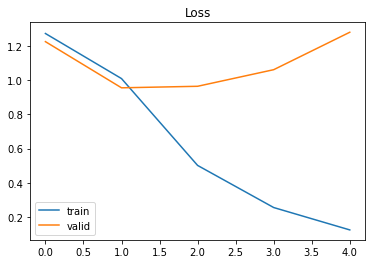

In [24]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.legend()
plt.show();

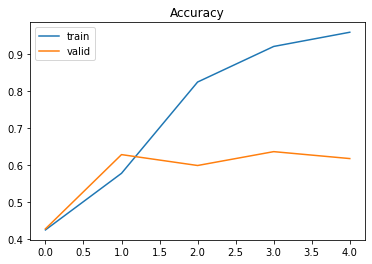

In [25]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='valid')
plt.legend()
plt.show();

In [35]:
y_pred = model.predict_classes(X_test)
y_true = list(df_test["label"])

In [37]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.78      0.75       558
           1       0.71      0.55      0.62       357
           2       0.40      0.39      0.40       123
           3       0.59      0.66      0.63       382

    accuracy                           0.66      1420
   macro avg       0.61      0.60      0.60      1420
weighted avg       0.66      0.66      0.65      1420



In [38]:
print(confusion_matrix(y_true, y_pred))

[[434  29  28  67]
 [ 60 198  21  78]
 [ 32  16  48  27]
 [ 73  34  23 252]]


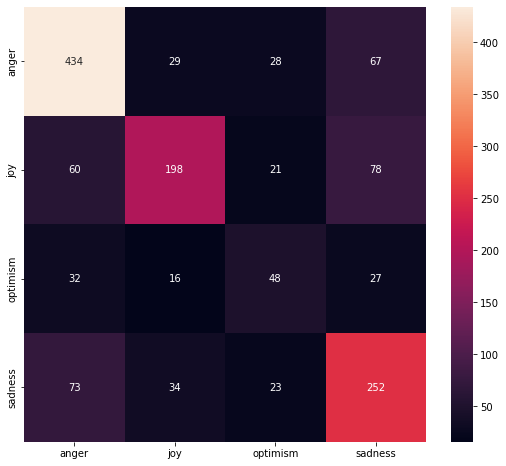

In [54]:
fig, ax = plt.subplots(figsize=(9,8))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d",
            xticklabels=["anger", "joy", "optimism", "sadness"],
            yticklabels=["anger", "joy", "optimism", "sadness"], 
            ax=ax)
plt.show()